# CNN For Brain Tumor Identification

In [1]:
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
print(os.getcwd())

C:\Users\kevvl\OneDrive\Desktop\ML projects\Brain img classifier


In [3]:
data_dir_path = "C:/Users/kevvl/OneDrive/Desktop/ML projects/Brain img classifier/Data"

In [4]:
os.listdir(data_dir_path)

['no', 'yes']

## Data Pipeline Setup

For this project, the dataset used is the [Br35H :: Brain Tumor Detection 2020](https://www.kaggle.com/datasets/ahmedhamada0/brain-tumor-detection) from Kaggle. This dataset contains 3,000 RGB MRI brain scan images, categorized as either tumor-positive or tumor-negative. To efficiently utilize this dataset, a data pipeline is constructed using the `image_dataset_from_directory` function provided by the Keras library.

This function simplifies the process of loading and preprocessing the images by creating a `tf.data.Dataset` object. It automatically labels the images based on their directory structure (tumor absent or present), and handles tasks like batching and shuffling. This pipeline ensures that the data is prepared and fed into the model efficiently during training.
In TensorFlow, batches of data can be created using the iterator provided by the tf.data.Dataset object. By default, the iterator generates batches of size 32. Understanding the shape of the data is crucial for configuring the input layer of a neural network.
For image data, the shape of each image and batch is important. The dimensions of a single image in the batch can be determined using images[0].shape. For example, a shape of (256, 256, 3) indicates that each image is 256 pixels in height and 256 pixels in width, with 3 color channels (RGB), meaning that the image is in color.
The shape of the entire batch of images can be obtained using images.shape. A shape of (32, 256, 256, 3) means that the batch contains 32 images, each with a height of 256 pixels, a width of 256 pixels, and 3 color channels. This information is essential for setting up the input layer of the neural network to match the dimensions of the data being fed into it

In [5]:
data = tf.keras.utils.image_dataset_from_directory(data_dir_path)

Found 3000 files belonging to 2 classes.


In [6]:
 data_iterator = data.as_numpy_iterator()

In [7]:
batch = data_iterator.next()

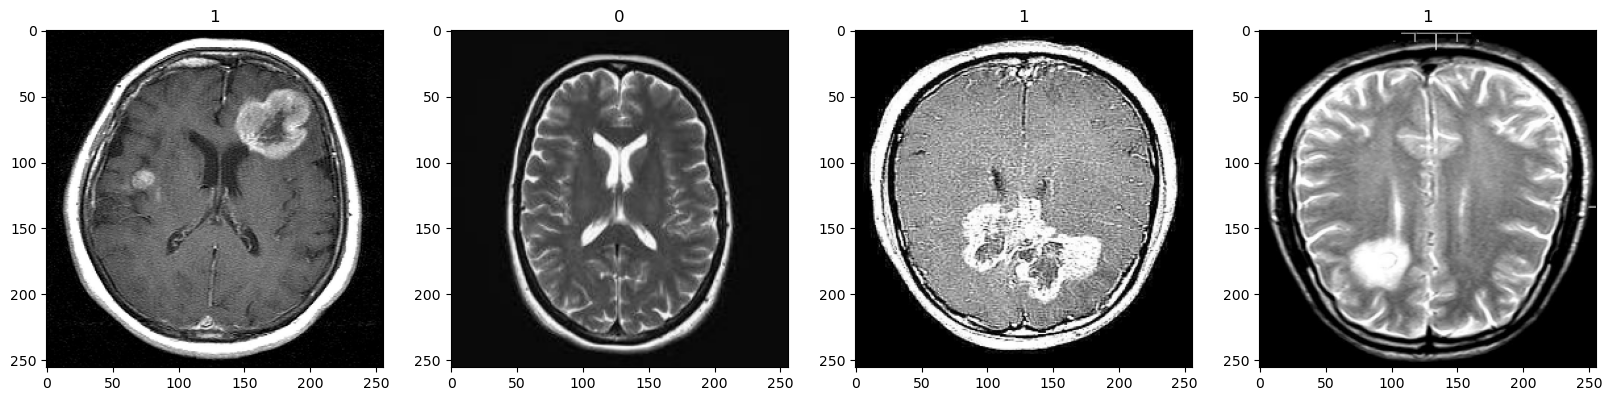

In [8]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## Image Preprocessing
Before creating the model, the images in the dataset need to be preprocessed. Although the dataset does not contain any problematic images requiring removal, normalization of image values is necessary. Since each image is in RGB color format, each pixel value ranges from 0 to 255. These pixel values can be large, potentially slowing down the learning process. To address this, RGB values should be normalized to the range [0, 1]. This is achieved using the transformation `data.map(lambda x, y: (x / 255.0, y))`, where each image tensor x is divided by 255, the maximum RGB value.

In [9]:
for images, labels in data.take(1):
    print(images[0].shape)
    print(images.shape)

(256, 256, 3)
(32, 256, 256, 3)


In [10]:
data = data.map(lambda x,y: (x/255, y))

In [11]:
# 94 batches of 32 images each 
len(data)

94

## Train, Test, Validation Split
With 94 batches of data available, it is important to split these batches into training, validation, and testing sets. 70% of the data will be allocated to the training set, 20% to the validation set, and the remaining 10% to the testing set. This distribution ensures that the model is trained on the majority of the data while reserving a portion for validating and testing its performance.


In [12]:
# Train test val split
training_size = int(len(data)*0.7) + 1
validation_size = int(len(data)*0.2) + 1
testing_size = int(len(data)*0.1)
print(training_size)
print(validation_size)
print(testing_size)

66
19
9


In [13]:
# Setup training, val, and testing data
training_data = data.take(training_size)
val_data = data.skip(training_size).take(validation_size)
test_data = data.skip(training_size+validation_size).take(testing_size)

## Building the Model
When working with image data, a convolutional network (CNN) can process and learn from data much more effectively than a dense network due its abiliy to process spatial hiearchies in data. CNNS have layers with filters that move across different areas of the image to detect various features like shapes, shadows, and orientations. In the model below, convolutional layers are followed by pooling layers which reduce spatial dimensions of the feature maps allowing for a more efficient learning process. The model comprises three convolutional layers, each paired with a corresponding pooling layer. A flatten converts the feature map into a one-dimensional vector which further optimizes the model's efficiency. Since the task is binary classification, a sigmoid activation is used in the output layer to produce a probability score.

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [15]:
model = Sequential()

In [16]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

C:\Users\kevvl\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    14,745,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,769,697 (56.34 MB)

 Trainable params: 14,769,697 (56.34 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
log_dir_path = "C:/Users/kevvl/OneDrive/Desktop/ML projects/Brain img classifier/Logs"

In [20]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir_path)

## Training the Model

In [21]:
model_history = model.fit(training_data, epochs=7, validation_data=val_data, callbacks=[tensorboard_callback])

Epoch 1/7
66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 385ms/step - accuracy: 0.7203 - loss: 0.6315 - val_accuracy: 0.8799 - val_loss: 0.2968
Epoch 2/7
66/66 ━━━━━━━━━━━━━━━━━━━━ 24s 360ms/step - accuracy: 0.9153 - loss: 0.2303 - val_accuracy: 0.8651 - val_loss: 0.3037
Epoch 3/7
66/66 ━━━━━━━━━━━━━━━━━━━━ 24s 369ms/step - accuracy: 0.9427 - loss: 0.1501 - val_accuracy: 0.9638 - val_loss: 0.1076
Epoch 4/7
66/66 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9730 - loss: 0.0809 - val_accuracy: 0.9622 - val_loss: 0.1157
Epoch 5/7
66/66 ━━━━━━━━━━━━━━━━━━━━ 24s 361ms/step - accuracy: 0.9901 - loss: 0.0383 - val_accuracy: 0.9852 - val_loss: 0.0603
Epoch 6/7
66/66 ━━━━━━━━━━━━━━━━━━━━ 24s 359ms/step - accuracy: 0.9987 - loss: 0.0178 - val_accuracy: 0.9836 - val_loss: 0.0868
Epoch 7/7
66/66 ━━━━━━━━━━━━━━━━━━━━ 24s 362ms/step - accuracy: 0.9864 - loss: 0.0358 - val_accuracy: 0.9836 - val_loss: 0.0649


## Visualizing Loss
Below, the training and validation loss is plotted. Both training and validation loss decrease each epoch which indicates that the model is learning and making less errors over each iteration of the training process.

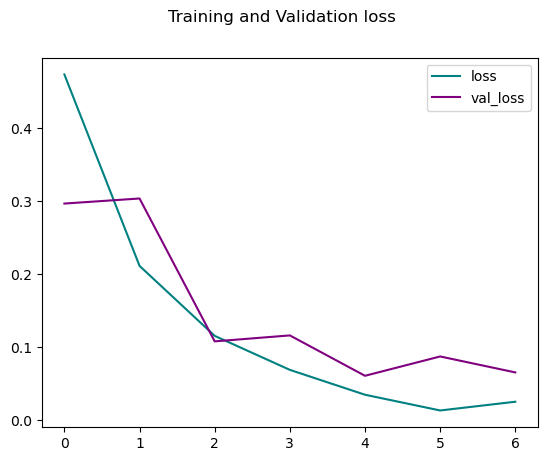

In [22]:
# plot loss
loss = plt.figure()
plt.plot(model_history.history['loss'], color='teal', label='loss')
plt.plot(model_history.history['val_loss'], color='purple', label='val_loss')
loss.suptitle("Training and Validation loss")
plt.legend(loc='upper right')
plt.show()

## Visualizing Accuracy
Below, the training and validation accuracy is plotted. Both training and validation accuracy increase each epoch indicating that the model is performing well and that there is no overfit.

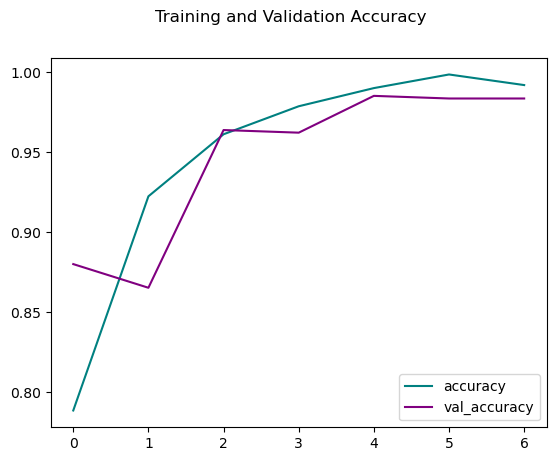

In [23]:
# plot accuracy
accuracy = plt.figure()
plt.plot(model_history.history['accuracy'], color='teal', label='accuracy')
plt.plot(model_history.history['val_accuracy'], color='purple', label='val_accuracy')
accuracy.suptitle("Training and Validation Accuracy")
plt.legend(loc='lower right')
plt.show()

In [24]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [25]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

## Evalutating on the Test Set
Model performance will be evaluated using three metrics: precision, recall, and accuracy.

Precision is a ratio of the correctly predicted positives to the total number of predicted positives. A high level of percision suggests that if the model predicts a positive class, that prediction is highly likely to be correct.

Recall is a ratio of the correctly predicted positives to the total number of actual positives. A high recall suggests that the model is able to correctly capture most of the positive instances. In other words, high recall means the model produces very few false alarms.

Accuracy is a ratio of the correct predictions to the total number of observations. High accuracy provides an overall score for model correctness; however, it can be misleading in the case of imbalanced datasets. For this model, the positive and negative classes contained the same number of images, so accuracy can be used as a non-biased measure of model performance.

In [26]:
for batch in test_data.as_numpy_iterator():
    X, y = batch
    pred = model.predict(X)
    precision.update_state(y, pred)
    recall.update_state(y, pred)
    accuracy.update_state(y, pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


In [27]:
print(precision.result())
print(recall.result())
print(accuracy.result())

tf.Tensor(0.97202796, shape=(), dtype=float32)
tf.Tensor(0.97202796, shape=(), dtype=float32)
tf.Tensor(0.9714286, shape=(), dtype=float32)


## Visualizing Predictions
The code below generates a plot showing the actual image class and the class predicted by the model.

In [28]:
# generate visualizations of predicted vs actual 
images = []
labels = []
predictions = []

for batch in test_data.as_numpy_iterator():
    X, y = batch
    pred = model.predict(X)
    
    pred_binary = (pred > 0.5).astype(int)
    
    images.extend(X)
    labels.extend(y)
    predictions.extend(pred_binary)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


In [29]:
# plot images 
def plot_images(images, labels, predictions, num_images_displayed):
    plt.figure(figsize=(20,20))
    for i in range(num_images_displayed):
        plt.subplot(1, num_images_displayed, i + 1)
        plt.imshow((images[i]*255).astype(int))
        plt.title(f"Actual: {labels[i]}, Predicted: {predictions[i]}")
        plt.axis('off')
    plt.show()

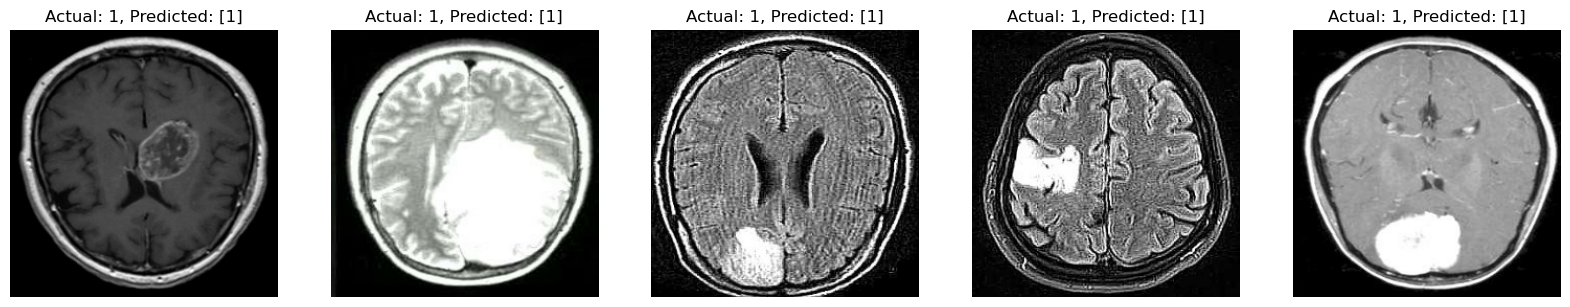

In [30]:
plot_images(images, labels, predictions, 5)